# Build your own Fitbit App

Data is cool, but what is cooler than looking at other people's data? Looking at your own Data! In this project we will construct our own miniature app that uses the Fitbit API to pull our own data. If you don't own a Fitbit, don't worry! You can download the free Fitbit app for iOS or Android and it will still log your steps using the accelorometer in your phone. Having a Fitbit device is slightly more exciting: it will log your sleep and heart rate as well (if you have a heart rate enabled device).

# Step I: Register your own app

There is a bit of setup that you will need to go through before you can actually pull your own data. Fitbit requires you to register an app in order to do this. In order to do this you will need to create a Fitbit account, and then follow the instructions found in [step 1 of this article](https://towardsdatascience.com/collect-your-own-fitbit-data-with-python-ff145fa10873).

# Step 2: Authenticate using our OAuth token
Now that we have a personal app that supplies us with a OAuth credentials we can authenticate and pull our data from Fitbit using our app. In order to do this we'll use some external libraries. Note that you will probably want to run this notebook locally (e.g. not on the jupyter hub instance) since an authentication tab will open up in your browser, and if you are working remotely it may not foward correctly.

In [1]:
# Required packages
import fitbit
import utils.gather_keys_oauth2 as Oauth2
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
pd.set_option('max.rows', 100)
pd.set_option('max.columns', 100)
plt.style.use('ggplot')

In [3]:
data_dir = '/Users/bbradshaw/nhanes/'

In [4]:
%matplotlib inline

In [5]:
##################################################################
# YOU SHOULD SET YOUR FITBIT CLIENT ID AND SECRET AS ENVIRONMENT #
# VARIABLES RATHER THAN PLACING THEM AS RAW TEXT IN YOUR SCRIPT. #
# ANYONE WHO VIEWS YOUR CREDENTIALS CAN PULL YOUR DATA.          #
##################################################################
CLIENT_ID = os.environ['FITBIT_CLIENT_ID']
CLIENT_SECRET = os.environ['FITBIT_CLIENT_SECRET']

In [6]:
# Instantiate OAuth server
server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
# Request to be authorized via OAuth
server.browser_authorize()
# Save access token
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
# Save refresh token
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])

# Instantiate connection
auth2_client = fitbit.Fitbit(
    CLIENT_ID,
    CLIENT_SECRET,
    oauth2=True,
    access_token=ACCESS_TOKEN,
    refresh_token=REFRESH_TOKEN
)

[15/May/2018:09:32:39] ENGINE Listening for SIGTERM.
[15/May/2018:09:32:39] ENGINE Listening for SIGHUP.
[15/May/2018:09:32:40] ENGINE Listening for SIGUSR1.
[15/May/2018:09:32:40] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[15/May/2018:09:32:40] ENGINE Started monitor thread 'Autoreloader'.
[15/May/2018:09:32:40] ENGINE Serving on http://127.0.0.1:8080
[15/May/2018:09:32:40] ENGINE Bus STARTED


127.0.0.1 - - [15/May/2018:09:32:41] "GET /?code=53959310df6502e6b13deac0e638721268bfc165&state=CUvRppTvQM0UMV06gkFd8SAGfd1HzW HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36"


[15/May/2018:09:32:42] ENGINE Bus STOPPING
[15/May/2018:09:32:47] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[15/May/2018:09:32:47] ENGINE Stopped thread 'Autoreloader'.
[15/May/2018:09:32:47] ENGINE Bus STOPPED
[15/May/2018:09:32:47] ENGINE Bus EXITING
[15/May/2018:09:32:47] ENGINE Bus EXITED
[15/May/2018:09:32:47] ENGINE Waiting for child threads to terminate...


# Pull our Data

Voile! We have a working connection to our app that allows us to pull our Fitbit data! Our next step is to take the raw response and parse it into the our standard data analysis object- a pandas dataframe. In this section we will pull the steps data. If you have a Fitbit device you can also pull sleep and heart rate data from the api.

In [6]:
def pull_date_activity(connection, date_string, endpoint='activities/steps'):
    """
    Pull activity from an endpoint for a given day
    
    Inputs:
        connection: Connection to your Fitbit app
        endpoint: API endpoint you want to pull data from
        date_string: Date string of the form "yyyy-mm-dd"
    Returns:
        Pandas DataFrame of values for requested activity for the requested date
    """
    result_set = connection.intraday_time_series(
        endpoint,
        base_date=date_string
    )
    
    act_type = endpoint.split('/')[1]
    get_key = f'activities-{act_type}-intraday'
    df = pd.DataFrame.from_dict(result_set[get_key]['dataset'])
    df['timestamp'] = date_string + ' ' + df['time']
    df['timestamp'] = pd.to_datetime(df.timestamp)
    df.drop(columns='time', inplace=True)
    df.set_index('timestamp', inplace=True)
    df.rename(columns={'value': act_type}, inplace=True)
    return df
    

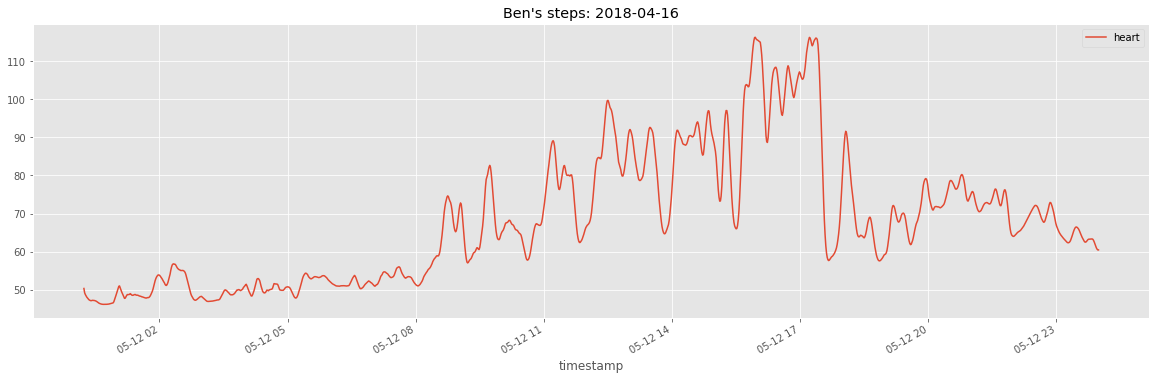

In [42]:
test_date = pull_date_activity(
    auth2_client,
    '2018-05-12',
    endpoint='activities/heart'
)

test_date.rolling(window=15, win_type='triang').mean().plot(figsize=(20, 6), title="Ben's steps: 2018-04-16")

Nice! Now I have my fitbit data for a specific day, and can start tracking my own behavior patterns. One thing that immediately stands out is how little I walk throughout the day, that's something I'll need to improve! Next let's pull a time range of data and concatenate it into a single dataframe.

In [22]:
def pull_act_range(start_date, end_date, connection, endpoint='activities/steps'):
    """
    Pulls data from the specified endpoint for each day of the range
    specified.
    
    Inputs:
        start_date (str): strftime date of the form YYYY-mm-dd
        end_date (str): strftime date of the form YYYY-mm-dd
        connection: Connection to your Fitbit app
        endpoint: API endpoint you want to pull data from
        
    Returns:
        Pandas DataFrame with minute level data for the specified endpoint.
    """
    act_dfs = []
    date_rng = pd.date_range(start=start_date, end=end_date, freq='D')
    
    for date in date_rng:
        str_date = date.strftime('%Y-%m-%d')
        append_df = pull_date_activity(
            connection=connection,
            date_string=str_date,
            endpoint=endpoint
        )
        
        act_dfs.append(append_df)
        
    return pd.concat(act_dfs)

In [23]:
# Pull in my steps data for a month
steps = pull_act_range('2018-04-15', '2018-05-14', auth2_client)

In [31]:
# Pull in my heart rate data for a month
heart = pull_act_range('2018-04-15', '2018-05-14', auth2_client, 'activities/heart')

In [35]:
# Join both sources into a single dataframe
full_act_data = steps.join(heart, how='left')

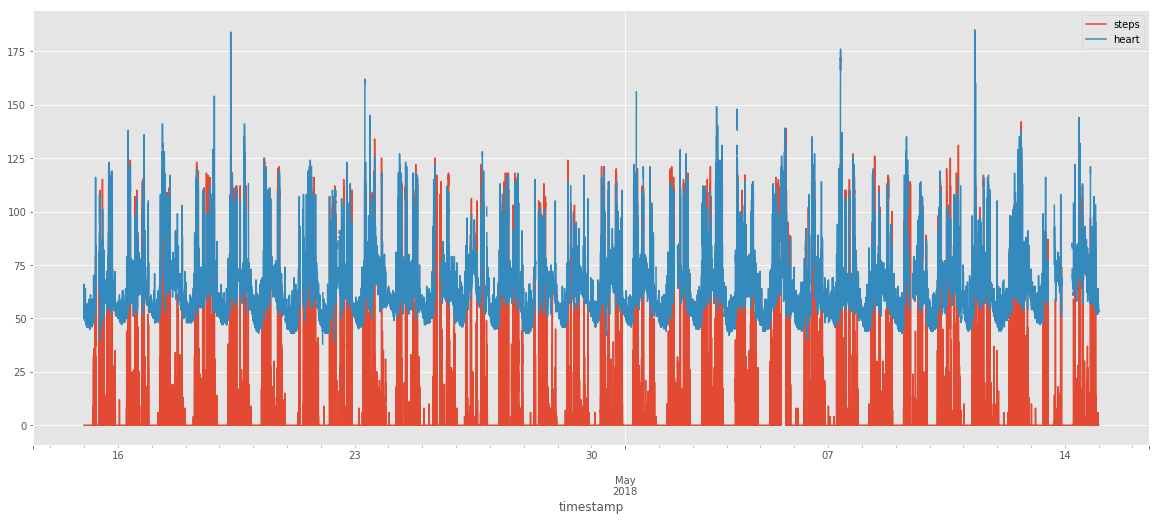

In [44]:
# How's it looking?
full_act_data.plot(figsize=(20,8));

In [47]:
# Write to disk to prevent us to have to hit the API again
full_act_data.to_csv(os.path.join(data_dir, 'bbradshaw_fbml_data.csv'))

# Exercises

The following exercises are designed to help get your creative juices flowing and expose you to some of the kinds of questions you can answer using this type of data.

## Exercise 1: Feature Engineering

The *intraday series* that gets returned by the fitbit API provides us the number of steps for each minute of a particular day. Often times this series is very interesting by itself for exploratory work, however often times for machine learning applications we are more interested in computing features that are a function of the minute level series.

### Part A: Creating a dataset

Use the function ```pull_date_activity``` (defined above) to pull your steps data for a specific day. The function returns a dataframe with an index that is the datetime of the observation, and the returned column is the type of activity requested from the API. Save this dataframe to a variable named ```day_steps```. Verify that this dataframe has 1440 rows corresponding to each minute of the day you chose.

In [ ]:
# Your code here

### Part A Solution

In [16]:
day_steps = pull_date_activity(auth2_client, '2018-04-12')

In [17]:
# Check that there are 1440 rows.
assert len(day_steps) == 1440

### Part B: Basic feature engineering
Our goal in this part is to create a variety of features from the 1440 rows that correspond to each minute of the day of your step data. Let's create the following basic features:

- ```max_steps```
- ```min_steps```
- ```mean_steps```
- ```median_steps```
- ```std_steps```

Compute each of the above features and save them in a dataframe where the columns of the dataframe are the features, and the index is the day over which you computed the feature. For a bit more practice writing reuseable code, try bundling this functionality into a function.

In [ ]:
# Your code here

### Part B Solution

In [18]:
def compute_summary_stats(df, col, stats):
    """
    Compute summary statisitics on an activity series and return a summary dataframe.
    
    Inputs:
        df (Pandas DataFrame): DataFrame containing intraday activity data
        col (str): Intraday activity column we would like to compute activities over.
        stats (list): The list of summary statistics you want to compute, should be a method on a pandas series
        
    Returns:
        Pandas DataFrame of summary statistics
    """
    index = [df.index.date[0].strftime('%Y-%m-%d')]
    return pd.DataFrame({stat: getattr(df[col], stat)() for stat in stats}, index=index)

In [19]:
compute_summary_stats(day_steps, 'steps', ['mean', 'std', 'median', 'max', 'min'])

,max,mean,median,min,std
2018-04-12,114,6.007639,0.0,0,20.515641


### Part C: Some more. . ."interesting" features

Let's compute some slightly more complicated (interesting?) features. These are more difficult to compute, but offer more insight into behavior. Try to compute the features decribed below. Some of them aren't super straight forward to compute- but that's ok! Each one will build your skills and will be a very useful feature for machine learning.

Features to compute:
- ```last_step_index```: The last minute index of a day for which you logged non-zero steps
- ```max_rolling10_steps```: The 10 minute window during a day where you logged the maximum cumulative steps
- ```nonzero_minute_count``` The number of minutes in a day during which you had non-zero steps

In [ ]:
# Your code here

### Part C Solutions

In [57]:
def compute_last_step(df):
    """
    Compute the index of the last non-zero step taken during a day
    
    Inputs:
        df (Pandas DataFrame): DataFrame over which we want to compute the feature
        
    Returns:
        The index corresponding to the last non-zero step taken during the day
    """
    return np.max(np.nonzero(df.steps.values))


def compute_max_rolling_k(df, k):
    """
    Get the max rolling window of length k
    
    Inputs:
        df (Pandas DataFrame): DataFrame over which we want to compute the feature
        k (int): Window length
        
    Returns:
        Maximum rolling window of length k
    """
    return df.steps.rolling(window=k).sum().max()


def compute_nonzero_minutes(df):
    """
    Compute the number of minutes in a day that had non-zero steps
    
    Inputs:
        df (Pandas DataFrame): DataFrame over which we want to compute the feature
    
    Returns:
        The count of minutes in a day where the step count was greater than zero
    """
    return len(np.nonzero(df.steps.values)[0])

In [34]:
compute_last_step(day_steps)

1351

In [60]:
compute_max_rolling_k(day_steps, 60)

2693.0

In [68]:
compute_nonzero_minutes(day_steps)

170

### Part D: Fun with groupby

Let's extend our concept of feature engineering to multiple days now. Use the ```pull_act_range``` function to pull a range of days of your walk or heart rate data (if you are collecting heart rate data). Suppose you want to compute features over not just one day but multiple days. How could we efficiently do this? Let's start by creating a dataframe that has two days worth of data.

In [48]:
# Create a dataframe with four days of data - you should choose dates for which you have a full days worth of data
two_day_sample = pull_act_range('2018-04-15', '2018-04-16', auth2_client)

In [50]:
# Add a new column that we will use for groupby operations
two_day_sample.reset_index(inplace=True)

In [52]:
# Here we are adding a "date" column that can be used for grouping operations
two_day_sample['date'] = two_day_sample.timestamp.dt.date

In [53]:
# Check to make sure everything worked out
two_day_sample.head()

,timestamp,steps,date
0,2018-04-15 00:00:00,0,2018-04-15
1,2018-04-15 00:01:00,0,2018-04-15
2,2018-04-15 00:02:00,0,2018-04-15
3,2018-04-15 00:03:00,0,2018-04-15
4,2018-04-15 00:04:00,0,2018-04-15


In [54]:
two_day_sample.set_index('timestamp', inplace=True)

Now that we have a single dataframe with two days worth of data we can compute features over each day by using a *groupby operation*. Groupby operations allow us to apply a function over partitions of a dataframe along an axis (typically axis 0 which corresponds to the rows of a dataframe). If you are familiar with SQL then you will be very familiar with the concept. Let's see this in action using a simple groupby.

In [55]:
two_day_sample.groupby('date').steps.max()

date
2018-04-15    119
2018-04-16    125
Name: steps, dtype: int64

So what exactly did we do above? Let's break it down into digestable chunks:
1. We took a dataframe
2. We told pandas we wanted to split the dataframe by the unique values of the column date
3. We told pandas we wanted to compute an aggregate measure on the column steps
4. We finally specified the measure to be the arithmetic mean

Go ahead and try to do the same thing but use a different aggregate function such as the median or standard deviation.

In [85]:
# Your code here.

You can also apply *custom* functions to a groupby operation. Recall the functions we created in Part C: we can use all of these and apply them within each date partition in our data. Recall that each of those functions required a dataframe as an input. As such, we need to pass in a dataframe rather than a series. We can use the ```[[]]``` notation to subset a single column returned as a dataframe.

In [58]:
two_day_sample.groupby('date')[['steps']].apply(compute_last_step)

date
2018-04-15    1330
2018-04-16    1307
dtype: int64

By default pandas expects a function with a single argument and passes each partition of the group in as inputs to the function provided to the groupby. However you can pass in keyword arguments for functions that require more than one argument.

In [60]:
two_day_sample.groupby('date')[['steps']].apply(compute_max_rolling_k, k=30)

date
2018-04-15    3010.0
2018-04-16    3149.0
dtype: float64

Now that you have some of these tools in your tool belt, take some time to come up with some more features that you think may be useful for the weekend/weekday classifier we will be building later. Try to implement these on your own and apply them to each day of data that you have collected using the methods outlined above.